In [26]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
import yfinance as yf
from IPython.display import Markdown
from langchain_core.runnables import RunnableConfig
from langchain.schema import HumanMessage, AIMessage
import re
import datetime
from pykrx.stock import get_market_ticker_list, get_market_ticker_name
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_core.documents.base import Document
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers.string import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from markitdown import MarkItDown
from fpdf import FPDF
import warnings
import dotenv
import os

warnings.filterwarnings("ignore")
dotenv.load_dotenv()

True

In [27]:
class State(TypedDict):
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "tool_call Result"]

In [28]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [29]:
@tool
def write_pdf(content: str, filename: str = "output.pdf"):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """
    
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "C:\Windows\Fonts\MALGUN.TTF"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("malgun", "", font_path, uni=True)
        pdf.set_font("malgun", size=12)
    except:
        raise ValueError("한글 폰트가 존재하지 않습니다.")
    
    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./files/{filename}")

    print(f"PDF saved as ./files/{filename}")

    return {"content":content, "filename":filename}

In [30]:
tools = [TavilySearchResults(), PythonAstREPLTool(), write_pdf]
search_tool, code_tool, write_tool = tools

In [324]:
tool_node = ToolNode(tools, messages_key="tool_call")

In [32]:
llm_with_tools = llm.bind_tools(tools)

In [33]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [34]:
def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                  "query":state["messages"][-1]})

    return result.yes_no

In [35]:
def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    
    chain = prompt | llm

    if len(state["messages"]) > 4:
        history = state["messages"][-4:-1]
    else:
        history = state["messages"][:-1]

    answer = chain.invoke({"history":history,
                  "query":state["messages"][-1]})

    return {"messages":answer}

In [36]:
class IntentClassifier(BaseModel):
    """
    의도 분류 어시스턴트입니다.

    들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
    당신은 "code", "tool" 두개 중 하나로만 대답합니다.

    """

    binary : Literal["code", "tool"] = \
    Field(..., description="""  당신은 의도 분류 어시스턴트입니다.

                                들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
                                당신은 "code", "tool" 두개 중 하나로만 대답합니다.

                                1. code : "문제가 데이터 분석 혹은 코드 실행과 관련된 문제일 경우 반환하는 값"
                                ### code의 예시
                                - 삼성전자의 거래량을 분석해주세요.
                                - LS의 3월 21일 종가는 얼마인가요?
                                - 100 + 100은 얼마인가요?
                                - 로또번호 랜덤생성기 만들어주세요.
                                - ```python import matplotlib.pyplot as plt import numpy as np
                                    df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
                                    df['성인여부'] = df['나이'] >= 20

                                    plt.bar(df['이름'], df['나이'], color='skyblue')
                                    plt.title('이름별 나이')
                                    plt.xlabel('이름')
                                    plt.ylabel('나이')
                                    plt.show()
                                  ```

                                2. tool : "문제가 웹 서칭, 파일 관리, 일반 질의에 해당할 경우 반환하는 값"
                                ### tool의 예시
                                - 한국의 날씨는 어떤가요?
                                - 조사한 내용의 레포트 작성해주세요.
                                             """)

In [37]:
def intent_check(state:State):

    prompt = PromptTemplate.from_template("""

                당신은 의도 분류 어시스턴트입니다.

                들어온 질문이 어떤 의도를 지닌 질문인지 판단합니다.
                당신은 "code", "tool" 두개 중 하나로만 대답합니다.
                                          
                질문 : {query}
                                          
                """)
    
    chain = prompt | intent_checker

    result = chain.invoke({"query":state["messages"][-1]})

    return result.binary

In [38]:
history_checker = llm.with_structured_output(HistoryChecker)
intent_checker = llm.with_structured_output(IntentClassifier)

In [39]:
def history_node(state:State):
    return state

In [40]:
def intent_node(state:State):
    return state

In [404]:
def select(
    state: State,
):
    try:
        message = state["messages"][-1]
    except:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"이전 대화 기록이 존재하지 않습니다.")

    if len(state["messages"]) > 6:
        history = state["messages"][-6:-1]
    else:
        history = state["messages"][:-1]

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
                대화 기록 : {history}
                                          
                질문 : {query}
                                          
                """)

    result = llm_with_tools.invoke(state["messages"][-1].content)

    chain = prompt | llm_with_tools

    result = chain.invoke({"history":history,
                           "query":state["messages"][-1]})    

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls
        return {"messages":AIMessage(content=f"""{tool_calls[0]["name"]}이 실행되었습니다.
                                        """),
            "tool_call": [result]}
    else:
        return {"messages":AIMessage(content=f"""도구를 다시 실행하여야합니다. 신중히 검토하세요.
                                        """),
                                    "tool_call":None}

    

In [405]:
# def select(
#     state: State,
# ):
#     try:
#         message = state["messages"][-1]
#     except:
#         # 입력 상태에 메시지가 없는 경우 예외 발생
#         raise ValueError(f"이전 대화 기록이 존재하지 않습니다.")

#     if len(state["messages"]) > 6:
#         history = state["messages"][-6:-1]
#     else:
#         history = state["messages"][:-1]

#     prompt = PromptTemplate.from_template("""

#                 이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
#                 아래 대화 기록을 첨부합니다.
#                 대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.
                
#                 대화 기록 : {history}
                                          
#                 질문 : {query}
                                          
#                 """)

#     result = llm_with_tools.invoke(state["messages"][-1].content)

#     chain = prompt | llm_with_tools

#     result = chain.invoke({"history":history,
#                            "query":state["messages"][-1]})    

#     if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
#         tool_calls = result.tool_calls
#         return {"tool_call": tool_calls}
#     else:
#         return {"tool_call":None}

    

In [406]:
# 주식 DB를 만드는 함수 {"삼성전자":"005930, ... }

def create_stock_db():
    stock_dict = {}
    today = datetime.datetime.today()
    
    stock_list = get_market_ticker_list(today, market="KOSPI")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})
    
    stock_list = get_market_ticker_list(today, market="KOSDAQ")

    for stock in stock_list:
        stock_dict.update({get_market_ticker_name(stock):stock})

    return stock_dict

stock_db = create_stock_db()

In [407]:
def stock_search(state:State):

    """
    주식 검색 도구입니다.
    결과값으로 데이터프레임이 반환됩니다.
    입력 쿼리에서 주식이름을 추출한 후 모든 주식 데이터를 가져옵니다.
    """


    prompt = PromptTemplate.from_template("""
        당신은 주식 이름 추출기입니다.
        주어진 문장에서 주식이름만 추출하세요.

        ### 예시 1
        query : 삼성전자의 최근 1년에 대해서 분석해주세요.

        answer : 삼성전자

        ### 예시 2
        query : AJ홀딩스우의 최근 실적은 얼마인가요?

        answer : AJ홀딩스우

        ### 입력
        query : {query}

        answer : 

        """
        )
    
    chain = prompt | llm | StrOutputParser()

    stock_name = chain.invoke({"query":state["messages"][-1]})

    result = llm_with_tools.invoke(state["messages"][-1].content)

    try:
        stock_code = stock_db[stock_name.strip().upper()]   
    except:
        if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
            tool_calls = result.tool_calls
            
            return {"tool_call": [result]}
        else:
            return {"tool_call":None}
        

    
    # 예: 삼성전자 (한국거래소는 뒤에 '.KS'를 붙임)
    ticker = yf.Ticker(stock_code+".KS")

    df = ticker.history(period="max") # 기간: '1d', '5d', '1mo', '1y', 'max' 등

    return {"df":df.reset_index().to_dict()}

In [408]:
def stock_search(state:State):

    """
    주식 검색 도구입니다.
    결과값으로 데이터프레임이 반환됩니다.
    입력 쿼리에서 주식이름을 추출한 후 모든 주식 데이터를 가져옵니다.
    """


    prompt = PromptTemplate.from_template("""
        당신은 주식 이름 추출기입니다.
        주어진 문장에서 주식이름만 추출하세요.

        ### 예시 1
        query : 삼성전자의 최근 1년에 대해서 분석해주세요.

        answer : 삼성전자

        ### 예시 2
        query : AJ홀딩스우의 최근 실적은 얼마인가요?

        answer : AJ홀딩스우

        ### 입력
        query : {query}

        answer : 

        """
        )
    
    chain = prompt | llm | StrOutputParser()

    stock_name = chain.invoke({"query":state["messages"][-1]})

    result = llm_with_tools.invoke(state["messages"][-1].content)

    try:
        stock_code = stock_db[stock_name.strip().upper()]   
    except:
        if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
            tool_calls = result.tool_calls
            
            return {"messages":AIMessage(content=f"""{tool_calls[0]["name"]}이 실행되었습니다.
                                         """),
                "tool_call": [result]}
        else:
            return {"tool_call":None}
        

    
    # 예: 삼성전자 (한국거래소는 뒤에 '.KS'를 붙임)
    ticker = yf.Ticker(stock_code+".KS")

    df = ticker.history(period="max") # 기간: '1d', '5d', '1mo', '1y', 'max' 등

    return {"df":df.reset_index().to_dict()}

In [409]:
# # tavily_search_results_json, python_repl_ast, read_file, write_file, list_directory

# def tools(state:State):
#     try:
#         name = state["tool_call"]["name"]
#     except:
#         name = "llm"

#     if name == "tavily_search_results_json":

#         result = search_tool.invoke(state["tool_call"]["args"]["query"])
#         prompt = ChatPromptTemplate.from_messages([
#             ("system", """
#                         당신은 아래 내용을 이용하여 답변합니다.
#                         생각을 담지 말고 사실만을 전달하세요.
#                         내용 : {result}

#                         """),
#             ("human", "{query}")
#         ])

#         chain = prompt | llm

#         answer = chain.invoke({"result":result,
#                                "query":state["messages"][-1]})
        
#         return {"messages": answer}
    
#     elif name == "python_repl_ast":

#         if len(code_tool.locals) > 0:
#             pass
#         else:
#             try:
#                 code_tool.locals = pd.DataFrame(state["df"])
#             except:
#                 pass
            

#         code = state["tool_call"]["args"]["query"]
#         code_tool.invoke(code)

#         prompt = ChatPromptTemplate.from_messages([
#             ("system", """
#                         아래의 코드를 참고하여 질의에 대해 답변합니다.
#                         절대 코드에 대해 설명하지마세요.
#                         독자는 프로그래머가 아닙니다.
#                         항상 출력되는 값을 기준으로 설명합니다.
#                         데이터 분석과 관련된 코드가 입력된다면 항상상 인사이트를 포함하세요.
#                         단순한 코드라면 간단하게 대답합니다.

#                         코드 : {code}

#                         """),
#             ("human", "{query}")
#         ])

#         chain = prompt | llm

#         answer = chain.invoke({"code":code,
#                                "query":state["messages"][-1]})
        
#         return {"messages": answer}    

#     elif name =="write_pdf":
        
#         result = state["tool_call"]["args"]
        
#         # prompt = PromptTemplate.from_template("""
#         #             당신은 입력된 정보를 레포트로 만들어내는 역할을 담당하고 있습니다.
                    
#         #             루트디렉토리의 위치는 "./files/" 입니다. 디렉토리 내부에 파일을 만들어주세요.
#         #             만들어지는 파일 형태는 .pdf파일이어야합니다.
                                              
#         #             input : {input}
                    
#         #             """)

#         write_tool.invoke(result)

#         answer = AIMessage(f"{result['filename']} 생성 완료")

#         return {"messages" : answer}
#     else:

#         prompt = PromptTemplate.from_template("""
#                 질문에 대해 한글로 대답해주세요.

#                 질문 : {query}
#                 """
#                 )
        
#         chain = prompt | llm

#         return {"messages":chain.invoke({"query":state["messages"][-1]})}

In [410]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.
    
    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """

    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")    

In [411]:
answer_checker = llm.with_structured_output(AnswerChecker)

In [412]:
def answer(state:State):
    return state

In [413]:
def answer_check(state:State):
    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기입니다.
    
    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
                                          
    기존 History도 참고하세요.
                                          
    History : {history}
                            
    정답 : {answer}
                            
    질문 : {query}
    """)

    chain = prompt | answer_checker

    result = chain.invoke({"history" : state["messages"],
                            "answer": state["messages"][-1],
                            "query": state["messages"][-2]})
    
    if result.end == "tool":
        print("답변이 충분하지 않습니다. 도구 호출로 돌아갑니다.")
    else:
        pass
    
    return result.end

In [414]:
def pretty_print(state:State):

    print(f"\n\n===== Result =====\n\n")

    print(state["messages"][-1].content)

In [415]:
graph_builder = StateGraph(State)

In [416]:
graph_builder.add_node("history_node", history_node)
graph_builder.add_node("intent_node", intent_node)
graph_builder.add_node("stock_search", stock_search)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("answer", answer)
graph_builder.add_node("pretty_print", pretty_print)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"intent_node"})
graph_builder.add_conditional_edges("intent_node",
                            intent_check,
                            {"tool":"select",
                             "code":"stock_search"
                             })
graph_builder.add_edge("stock_search", "tools")
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "answer")
graph_builder.add_edge("memory_chat", "answer")
graph_builder.add_conditional_edges("answer",
                            answer_check,
                            {"end":"pretty_print",
                             "tool":"select"})
graph_builder.add_edge("pretty_print", END);

In [417]:
# graph.add_node("history_node", history_node)
# graph.add_node("intent_node", intent_node)
# graph.add_node("stock_search", stock_search)
# graph.add_node("memory_chat", memory_chat)
# graph.add_node("select", select)
# graph.add_node("tools", tools)
# graph.add_node("answer", answer)
# graph.add_node("pretty_print", pretty_print)


# graph.add_edge(START, "history_node")
# graph.add_conditional_edges("history_node",
#                             history_check,
#                             {"yes":"memory_chat",
#                              "no":"intent_node"})
# graph.add_conditional_edges("intent_node",
#                             intent_check,
#                             {"tool":"select",
#                              "code":"stock_search"
#                              })
# graph.add_edge("stock_search", "tools")
# graph.add_edge("select", "tools")
# graph.add_edge("tools", "answer")
# graph.add_edge("memory_chat", "answer")
# graph.add_conditional_edges("answer",
#                             answer_check,
#                             {"end":"pretty_print",
#                              "tool":"select"})
# graph.add_edge("pretty_print", END);

In [418]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [419]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": "1022"})

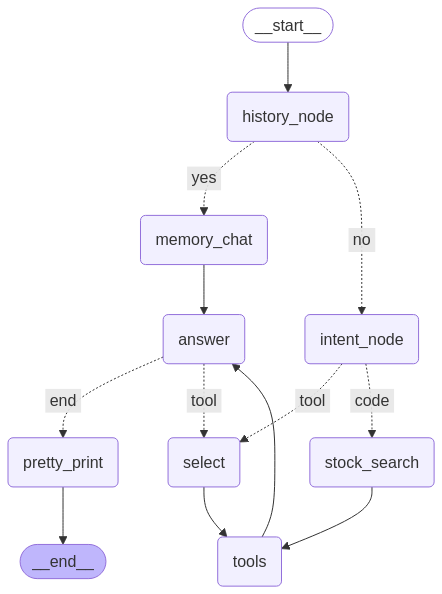

In [330]:
graph

In [398]:
result = graph.stream({"messages":("user", "예시 데이터프레임 만들어서 시각화까지 해줘")}, config=config)



=== history_node ===




=== intent_node ===




=== stock_search ===


          날짜   값
0 2023-01-01  45
1 2023-01-02  48
2 2023-01-03  65
3 2023-01-04  68
4 2023-01-05  68
5 2023-01-06  10
6 2023-01-07  84
7 2023-01-08  22
8 2023-01-09  37
9 2023-01-10  88


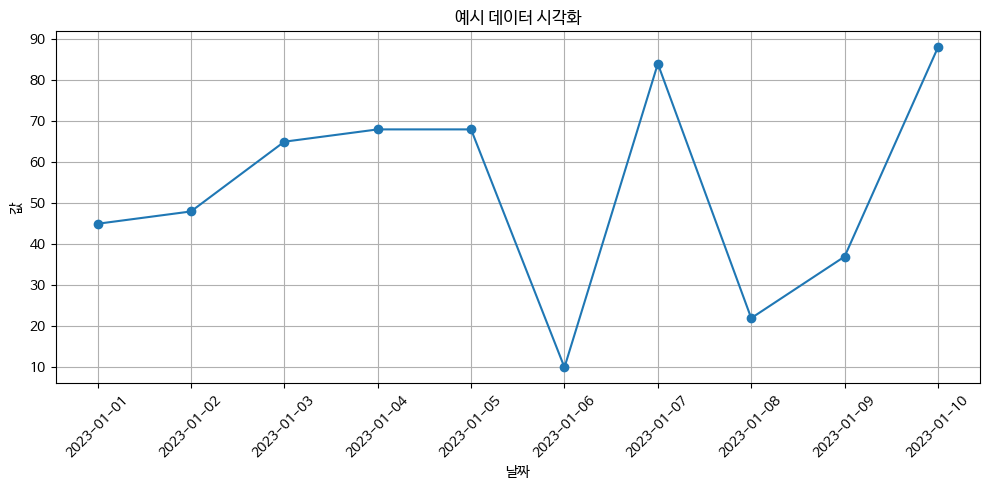



=== tools ===


답변이 충분하지 않습니다. 도구 호출로 돌아갑니다.


=== answer ===




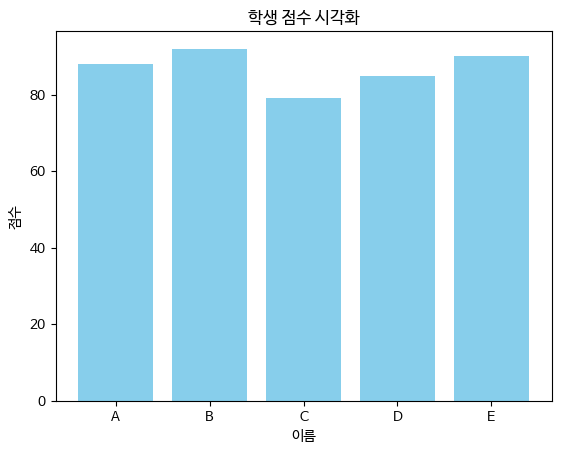



=== select ===




=== tools ===


답변이 충분하지 않습니다. 도구 호출로 돌아갑니다.


=== answer ===




=== select ===




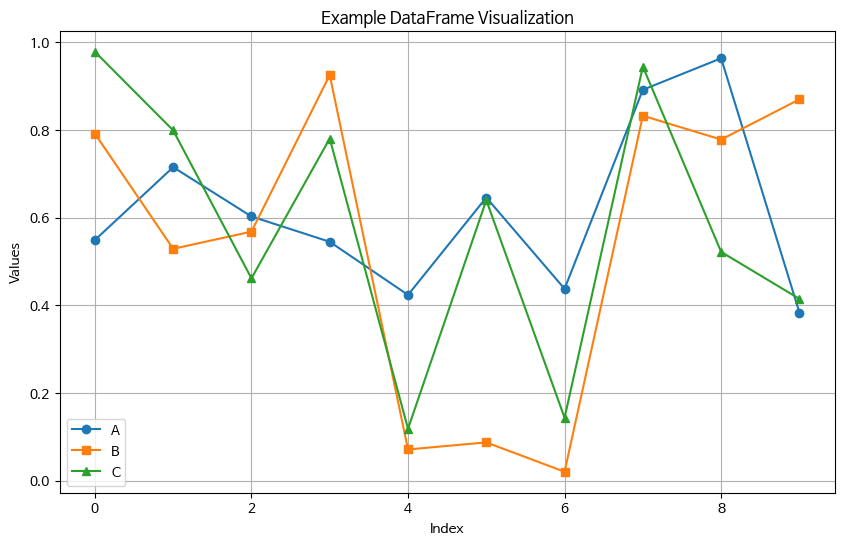



=== tools ===


답변이 충분하지 않습니다. 도구 호출로 돌아갑니다.


=== answer ===




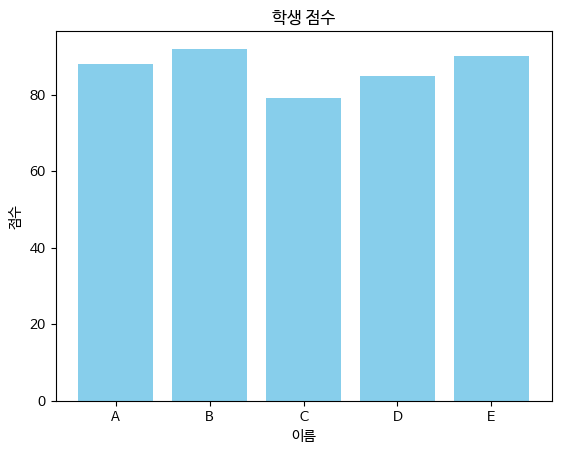



=== select ===


  이름  점수
0  A  88
1  B  92
2  C  79
3  D  85
4  E  90


=== tools ===




=== answer ===




===== Result =====


python_repl_ast이 실행되었습니다.
                                        


=== pretty_print ===




In [399]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        try:
            v["messages"][-1].prtty_print()
        except:
            pass

In [420]:
result = graph.stream({"messages":("user", "피엔티에 대해 자세하게 조사하고 조사한 내용을 레포트로 정리해서 pdf파일로 만들어주세요. \
                                 주식투자 의사결정에 이용할 거니까 매우 상세하게 조사하여야합니다.")}, config=config)

In [421]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")
        try:
            v["messages"][-1].prtty_print()
        except:
            print(v)



=== history_node ===


{'messages': [HumanMessage(content='피엔티에 대해 자세하게 조사하고 조사한 내용을 레포트로 정리해서 pdf파일로 만들어주세요.                                  주식투자 의사결정에 이용할 거니까 매우 상세하게 조사하여야합니다.', additional_kwargs={}, response_metadata={}, id='5d39ce83-cde8-4432-8da0-d0a8f6d118ad')]}


=== intent_node ===


{'messages': [HumanMessage(content='피엔티에 대해 자세하게 조사하고 조사한 내용을 레포트로 정리해서 pdf파일로 만들어주세요.                                  주식투자 의사결정에 이용할 거니까 매우 상세하게 조사하여야합니다.', additional_kwargs={}, response_metadata={}, id='5d39ce83-cde8-4432-8da0-d0a8f6d118ad')]}


=== select ===


{'messages': AIMessage(content='tavily_search_results_json이 실행되었습니다.\n                                        ', additional_kwargs={}, response_metadata={}, id='11df121e-555b-43da-a5fb-cf8b9229d55e'), 'tool_call': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HIc40qWMu4bWK9DdL8GebRSc', 'function': {'arguments': '{"query":"피엔티 주식"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}

GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [45]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": "8442"})

In [105]:
result = app.stream({"messages":("user", "피엔티라는 회사에 대해서 자세하게 조사하고 조사한 내용 레포트로 만들어서 제공해줘. \
                                 파일 이름은 알아서 결정하고 pdf형태로 만들어야해.")}, config=config)

In [106]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 

In [107]:
result = app.stream({"messages":("user", "방금 조사한 내용 pdf파일로 만들어줘")}, config=config)

In [108]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 

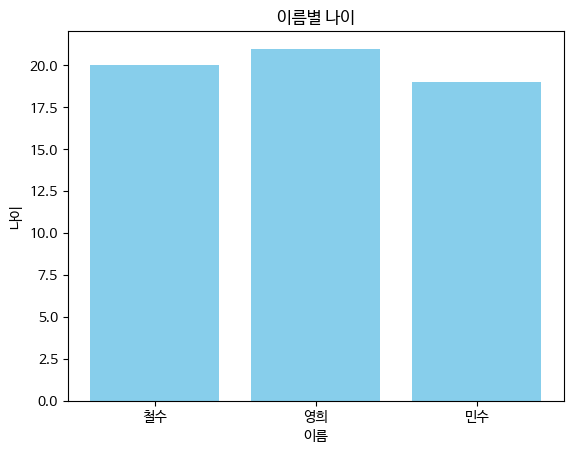



===== Result =====


이 코드는 세 명의 이름과 그에 해당하는 나이를 바 차트로 시각화합니다. 차트는 '이름별 나이'라는 제목을 가지고 있으며, 각 이름에 대한 나이를 보여줍니다. 

데이터를 보면, 철수는 20세, 영희는 21세, 민수는 19세입니다. 이 정보를 통해 성인 여부를 판단할 수 있으며, 철수와 영희는 성인으로 분류되고, 민수는 성인이 아닙니다. 

이러한 분석은 특정 그룹의 연령 분포를 이해하는 데 유용하며, 예를 들어, 특정 연령대의 인구 비율이나 성인과 미성년자의 비율을 파악하는 데 활용될 수 있습니다.


In [109]:
result = app.invoke({"messages":("user", """import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'이름': ['철수', '영희', '민수'], '나이': [20, 21, 19]})
df['성인여부'] = df['나이'] >= 20

plt.bar(df['이름'], df['나이'], color='skyblue')
plt.title('이름별 나이')
plt.xlabel('이름')
plt.ylabel('나이')
plt.show()
""")}, config=config)

In [110]:
result = app.stream({"messages":("user", """
무슨 주식을 사야하는지 고민되네. 찾아봐줘
""")}, config=config)

In [111]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 

In [112]:
result = app.stream({"messages":("user", "더 자세하게 알려줘")}, config=config)

In [113]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 

In [114]:
result = app.stream({"messages":("user", "조사한 내용을 바탕으로 보고서 작성해줘. 이름도 적절하게 설정하고 pdf파일로 저장해줘.")},config=config)

In [ ]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 

In [116]:
result = app.stream({"messages":("user", "방금 내용 pdf파일로 저장해줘.")},config=config)

In [117]:
for step in result:
    for k, v in step.items():
        print(f"\n\n=== {k} ===\n\n")

        # print(v["messages"][-1].content)
        print(v)



=== history_node ===


{'messages': [HumanMessage(content='1부터 20까지 반복문 코드를 파이썬으로 짜줘', additional_kwargs={}, response_metadata={}, id='d26cff86-4835-40fe-8760-d994364f19f8'), AIMessage(content='1부터 20까지 반복문을 사용하는 파이썬 코드는 다음과 같습니다:\n\n```python\nfor i in range(1, 21):\n    print(i)\n```\n\n이 코드는 1부터 20까지의 숫자를 하나씩 출력합니다. `range(1, 21)`은 1부터 20까지의 숫자를 생성하는 함수입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 117, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-16a4c444-0f40-47af-aa05-4cd0ec2bf136-0', usage_metadata={'input_tokens': 117, 'output_tokens': 79, 'total_tokens': 196, 'input_token_details': {'audio': 0, 